In [2]:
!pip install catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


#catboost ranker

In [18]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import train_test_split

# Генерация синтетических данных
np.random.seed(42)
n_queries = 1000
n_items_per_query = np.random.randint(3, 15, size=n_queries)
total_samples = sum(n_items_per_query)

# Создаем DataFrame
data = {
    'query_id': [],
    'price': np.random.uniform(10, 500, total_samples),
    'rating': np.random.uniform(1, 5, total_samples),
    'popularity': np.random.uniform(0, 1, total_samples),
    'relevance': []
}

# Заполняем данные
current_idx = 0
for query_idx in range(n_queries):
    n_items = n_items_per_query[query_idx]
    for item_idx in range(n_items):
        data['query_id'].append(query_idx)
        # Вычисляем релевантность (как в предыдущем коде)
        base_relevance = (0.3 * data['rating'][current_idx] +
                         0.4 * data['popularity'][current_idx] -
                         0.1 * data['price'][current_idx] / 100)
        noise = np.random.normal(0, 0.1)
        relevance_score = max(0, min(1, base_relevance + noise))

        if relevance_score > 0.7: relevance = 2
        elif relevance_score > 0.4: relevance = 1
        else: relevance = 0

        data['relevance'].append(relevance)
        current_idx += 1

df = pd.DataFrame(data)
print(f"Размер датасета: {len(df)}")
print(f"Количество уникальных query_id: {df['query_id'].nunique()}")

Размер датасета: 8454
Количество уникальных query_id: 1000


In [4]:
df

,query_id,price,rating,popularity,relevance
0,0,249.026802,2.590916,0.078469,1
1,0,426.900584,2.712454,0.448277,2
2,0,53.064936,4.520992,0.097598,2
3,0,404.873795,4.843617,0.727902,2
4,0,37.270210,4.572005,0.968941,2
...,...,...,...,...,...
8449,999,285.630938,4.618910,0.308949,2
8450,999,207.044266,4.589853,0.279788,2
8451,999,325.508031,1.212616,0.341570,0
8452,999,279.800516,3.437786,0.218458,2


In [12]:
group_id = df['query_id'].values

In [13]:
# Разделение на train/test по группам (query_id)
train_queries, test_queries = train_test_split(
    df['query_id'].unique(), test_size=0.2, random_state=42
)

train_df = df[df['query_id'].isin(train_queries)].copy()
test_df = df[df['query_id'].isin(test_queries)].copy()

# Подготовка признаков и целевой переменной
feature_cols = ['price', 'rating', 'popularity']
X_train = train_df[feature_cols]
y_train = train_df['relevance']
X_test = test_df[feature_cols]
y_test = test_df['relevance']

# Создаем group_id - ОЧЕНЬ ВАЖНО: той же длины, что и данные!
group_id_train = train_df['query_id'].values
group_id_test = test_df['query_id'].values

print(f"Train: данные={len(X_train)}, group_id={len(group_id_train)}")
print(f"Test: данные={len(X_test)}, group_id={len(group_id_test)}")

# Создаем Pool объекты
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=group_id_train  # Теперь длины совпадают!
)

eval_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=group_id_test   # Теперь длины совпадают!
)

# Создаем и обучаем модель
model = CatBoostRanker(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='YetiRank',
    random_seed=42,
    verbose=100,
    eval_metric='NDCG'
)

# Обучаем модель
model.fit(
    train_pool,
    eval_set=eval_pool,
    verbose=True
)

print("✅ Модель успешно обучена!")

Train: данные=6843, group_id=6843
Test: данные=1611, group_id=1611
0:	test: 0.9922469	best: 0.9922469 (0)	total: 65.1ms	remaining: 32.5s
1:	test: 0.9946180	best: 0.9946180 (1)	total: 77.7ms	remaining: 19.3s
2:	test: 0.9952893	best: 0.9952893 (2)	total: 90.7ms	remaining: 15s
3:	test: 0.9953993	best: 0.9953993 (3)	total: 107ms	remaining: 13.2s
4:	test: 0.9963993	best: 0.9963993 (4)	total: 120ms	remaining: 11.9s
5:	test: 0.9964956	best: 0.9964956 (5)	total: 132ms	remaining: 10.9s
6:	test: 0.9964010	best: 0.9964956 (5)	total: 144ms	remaining: 10.2s
7:	test: 0.9965422	best: 0.9965422 (7)	total: 157ms	remaining: 9.66s
8:	test: 0.9966291	best: 0.9966291 (8)	total: 170ms	remaining: 9.27s
9:	test: 0.9966599	best: 0.9966599 (9)	total: 183ms	remaining: 8.97s
10:	test: 0.9967351	best: 0.9967351 (10)	total: 200ms	remaining: 8.89s
11:	test: 0.9964453	best: 0.9967351 (10)	total: 213ms	remaining: 8.65s
12:	test: 0.9964585	best: 0.9967351 (10)	total: 225ms	remaining: 8.43s
13:	test: 0.9970673	best: 0.9

#lgbm ranker

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Используем предыдущий датасет (как в CatBoost примере)
np.random.seed(42)

# Создаем данные в том же формате, что и для CatBoost
n_queries = 1000
n_items_per_query = np.random.randint(3, 15, size=n_queries)
total_samples = sum(n_items_per_query)

print(f"Создаем {total_samples} samples в {n_queries} группах")

# Создаем DataFrame в том же формате
data = {
    'query_id': [],
    'price': np.random.uniform(10, 500, total_samples),
    'rating': np.random.uniform(1, 5, total_samples),
    'popularity': np.random.uniform(0, 1, total_samples),
    'relevance': []
}

# Заполняем данные (как в предыдущем примере)
current_idx = 0
for query_idx in range(n_queries):
    n_items = n_items_per_query[query_idx]

    for item_idx in range(n_items):
        data['query_id'].append(query_idx)

        # Вычисляем релевантность (исправляем ошибку с индексами)
        base_relevance = (0.3 * data['rating'][current_idx] +
                         0.4 * data['popularity'][current_idx] -
                         0.1 * data['price'][current_idx] / 100)

        noise = np.random.normal(0, 0.1)
        relevance_score = base_relevance + noise
        relevance_score = max(0, min(1, relevance_score))

        if relevance_score > 0.7:
            relevance = 2
        elif relevance_score > 0.4:
            relevance = 1
        else:
            relevance = 0

        data['relevance'].append(relevance)
        current_idx += 1

df = pd.DataFrame(data)
print("Данные созданы:")
print(f"Размер датасета: {len(df)}")
print(f"Количество запросов: {df['query_id'].nunique()}")
print("\nРаспределение релевантности:")
print(df['relevance'].value_counts().sort_index())

Создаем 8454 samples в 1000 группах
Данные созданы:
Размер датасета: 8454
Количество запросов: 1000

Распределение релевантности:
relevance
0    1285
1    1921
2    5248
Name: count, dtype: int64



=== Анализ распределения признаков ===
             price       rating   popularity
count  8454.000000  8454.000000  8454.000000
mean    255.623156     2.990628     0.501615
std     141.325512     1.144022     0.290901
min      10.091399     1.000475     0.000009
25%     134.498910     2.014812     0.248957
50%     258.634852     2.984438     0.499025
75%     377.309181     3.952492     0.757087
max     499.926130     4.999571     0.999891


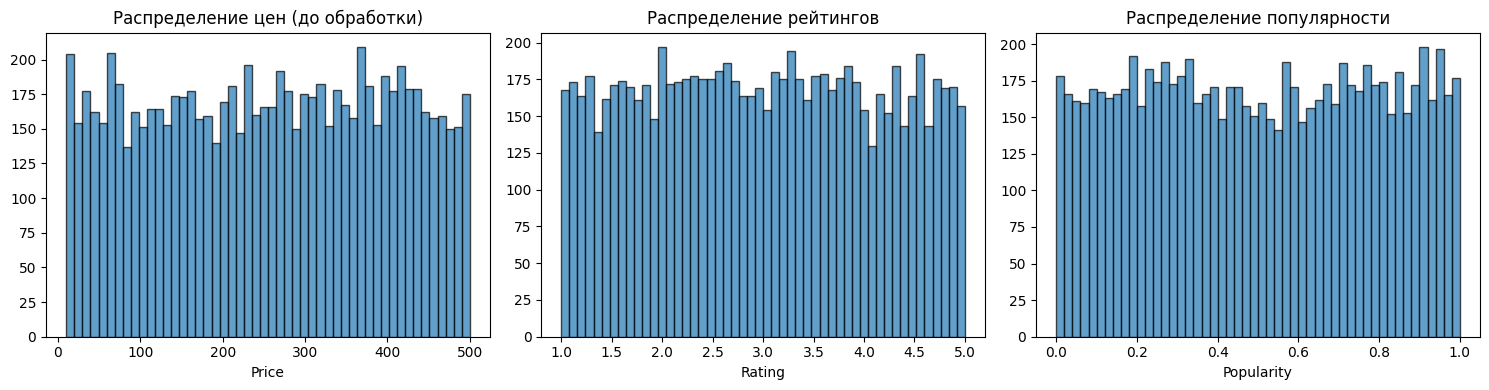

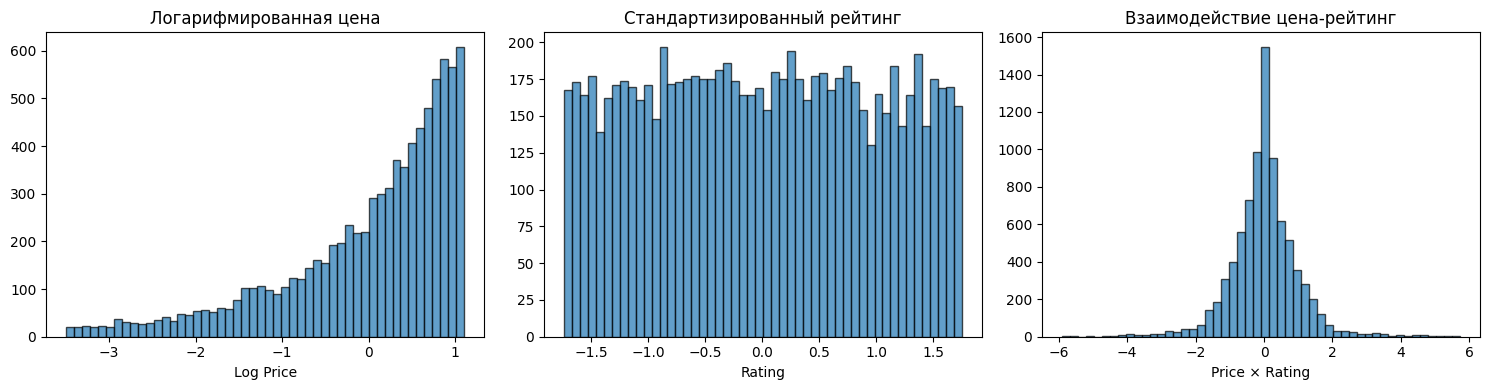


=== После обработки ===
Количество признаков: 9
Признаки: ['rating', 'popularity', 'log_price', 'price_squared', 'rating_squared', 'price_rating_interaction', 'price_popularity_interaction', 'price_bin', 'rating_bin']


In [3]:
# Анализ распределения признаков до обработки
print("\n=== Анализ распределения признаков ===")
print(df[['price', 'rating', 'popularity']].describe())

# Визуализация распределения до обработки
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение цен (до обработки)')
plt.xlabel('Price')

plt.subplot(1, 3, 2)
plt.hist(df['rating'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение рейтингов')
plt.xlabel('Rating')

plt.subplot(1, 3, 3)
plt.hist(df['popularity'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение популярности')
plt.xlabel('Popularity')

plt.tight_layout()
plt.show()

# Feature Engineering
df_processed = df.copy()

# 1. ЛОГАРИФМИРОВАНИЕ ЦЕНЫ (исправляем возможные проблемы)
df_processed['log_price'] = np.log1p(df_processed['price'])

# 2. СТАНДАРТИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ
numeric_features = ['log_price', 'rating', 'popularity']
scaler = StandardScaler()
df_processed[numeric_features] = scaler.fit_transform(df_processed[numeric_features])

# 3. СОЗДАНИЕ ПОЛИНОМИАЛЬНЫХ ПРИЗНАКОВ
df_processed['price_squared'] = df_processed['log_price'] ** 2
df_processed['rating_squared'] = df_processed['rating'] ** 2

# 4. СОЗДАНИЕ ВЗАИМОДЕЙСТВИЙ ПРИЗНАКОВ
df_processed['price_rating_interaction'] = df_processed['log_price'] * df_processed['rating']
df_processed['price_popularity_interaction'] = df_processed['log_price'] * df_processed['popularity']

# 5. БИННИНГ ПРИЗНАКОВ
df_processed['price_bin'] = pd.cut(df_processed['log_price'], bins=5, labels=False)
df_processed['rating_bin'] = pd.cut(df_processed['rating'], bins=5, labels=False)

# Визуализация после обработки
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df_processed['log_price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Логарифмированная цена')
plt.xlabel('Log Price')

plt.subplot(1, 3, 2)
plt.hist(df_processed['rating'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Стандартизированный рейтинг')
plt.xlabel('Rating')

plt.subplot(1, 3, 3)
plt.hist(df_processed['price_rating_interaction'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Взаимодействие цена-рейтинг')
plt.xlabel('Price × Rating')

plt.tight_layout()
plt.show()

print("\n=== После обработки ===")
feature_columns = [col for col in df_processed.columns if col not in ['query_id', 'relevance', 'price']]
print(f"Количество признаков: {len(feature_columns)}")
print("Признаки:", feature_columns)

In [4]:
# Определяем фичи
feature_columns = [col for col in df_processed.columns if col not in ['query_id', 'relevance', 'price']]

print(f"Используем {len(feature_columns)} признаков:")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i}. {feature}")

# Разделение на train/test по группам (query_id)
all_queries = df_processed['query_id'].unique()
train_queries, test_queries = train_test_split(all_queries, test_size=0.2, random_state=42)

train_df = df_processed[df_processed['query_id'].isin(train_queries)].copy()
test_df = df_processed[df_processed['query_id'].isin(test_queries)].copy()

print(f"\nРазделение данных:")
print(f"Train: {len(train_df)} samples, {train_df['query_id'].nunique()} queries")
print(f"Test: {len(test_df)} samples, {test_df['query_id'].nunique()} queries")

# Подготовка данных в формате для LightGBM
X_train = train_df[feature_columns]
y_train = train_df['relevance']
X_test = test_df[feature_columns]
y_test = test_df['relevance']

# Группы для LightGBM (ВАЖНО: количество элементов в каждой группе)
train_groups = train_df.groupby('query_id').size().values
test_groups = test_df.groupby('query_id').size().values

print(f"\nИнформация о группах:")
print(f"Train groups: {len(train_groups)} групп")
print(f"Test groups: {len(test_groups)} групп")
print(f"Размеры первых 10 train групп: {train_groups[:10]}")
print(f"Общее распределение размеров групп:")
print(pd.Series(train_groups).describe())

Используем 9 признаков:
1. rating
2. popularity
3. log_price
4. price_squared
5. rating_squared
6. price_rating_interaction
7. price_popularity_interaction
8. price_bin
9. rating_bin

Разделение данных:
Train: 6843 samples, 800 queries
Test: 1611 samples, 200 queries

Информация о группах:
Train groups: 800 групп
Test groups: 200 групп
Размеры первых 10 train групп: [ 9  6 13 10  7  9 12  5  9 13]
Общее распределение размеров групп:
count    800.000000
mean       8.553750
std        3.497127
min        3.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       14.000000
dtype: float64


In [15]:
# Улучшенные параметры для стабильного обучения
lgbm_ranker = LGBMRanker(
    objective='lambdarank',
    metric='ndcg',
    n_estimators=150,  # Уменьшаем количество деревьев
    learning_rate=0.1,
    num_leaves=31,
    max_depth=6,
    min_child_samples=5,
    min_split_gain=0.001,  # Минимальное улучшение для разбиения
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=1  # Оставляем для отслеживания
)

print("Начинаем обучение LightGBM Ranker...")

lgbm_ranker.fit(
    X_train, y_train,
    group=train_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_groups],
    eval_at=[3, 5]
)

print("✅ Обучение завершено!")

Начинаем обучение LightGBM Ranker...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1795
[LightGBM] [Info] Number of data points in the train set: 6843, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[


=== LightGBM Ranker - Качество ранжирования ===
NDCG@3: 0.9956
NDCG@5: 0.9939


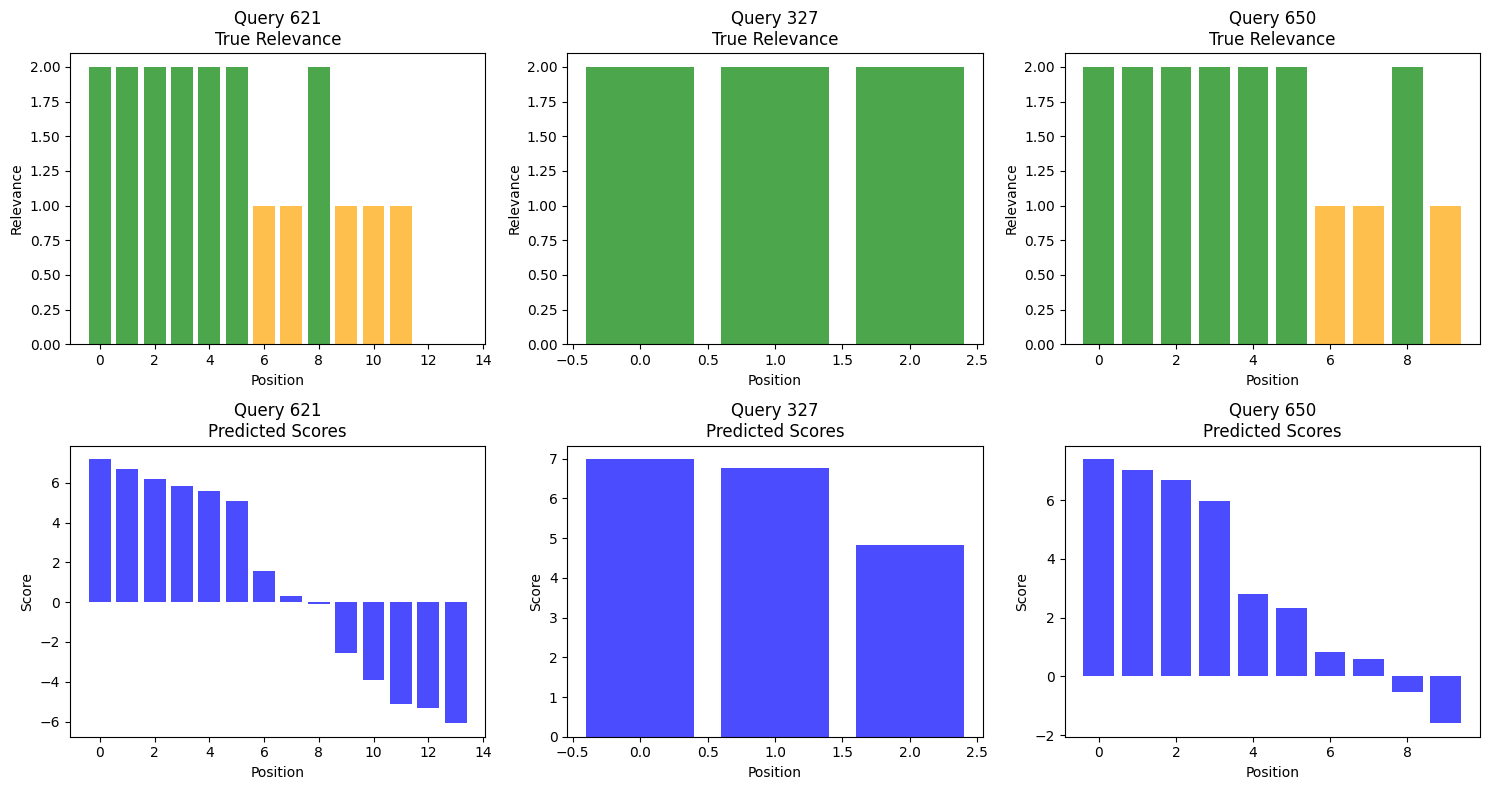

In [16]:
# Функция для анализа результатов ранжирования
def analyze_ranking_performance(test_df, model_name="LightGBM Ranker"):
    """Анализ качества ранжирования"""

    # Анализ по группам
    ndcg_results = []
    for query_id in test_df['query_id'].unique():
        query_data = test_df[test_df['query_id'] == query_id].sort_values('predicted_score', ascending=False)
        true_relevance = query_data['relevance'].values

        # Вычисляем NDCG@k
        for k in [3, 5]:
            if len(true_relevance) >= k:
                # DCG
                dcg = sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(true_relevance[:k]))
                # Ideal DCG
                ideal_relevance = np.sort(true_relevance)[::-1]
                idcg = sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_relevance[:k]))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_results.append({'query_id': query_id, 'k': k, 'ndcg': ndcg})

    ndcg_df = pd.DataFrame(ndcg_results)

    # Средний NDCG
    mean_ndcg = ndcg_df.groupby('k')['ndcg'].mean()
    print(f"\n=== {model_name} - Качество ранжирования ===")
    for k, score in mean_ndcg.items():
        print(f"NDCG@{k}: {score:.4f}")

    return ndcg_df

# Анализ качества
ndcg_df = analyze_ranking_performance(test_df)

# Визуализация результатов для нескольких запросов
def visualize_query_results(test_df, n_queries=3):
    """Визуализация результатов для конкретных запросов"""

    fig, axes = plt.subplots(2, n_queries, figsize=(5*n_queries, 8))
    if n_queries == 1:
        axes = axes.reshape(2, 1)

    sample_queries = np.random.choice(test_df['query_id'].unique(), n_queries, replace=False)

    for i, query_id in enumerate(sample_queries):
        query_data = test_df[test_df['query_id'] == query_id].sort_values('predicted_score', ascending=False)

        # График истинной релевантности
        axes[0, i].bar(range(len(query_data)), query_data['relevance'],
                      color=['red' if x == 0 else 'orange' if x == 1 else 'green' for x in query_data['relevance']],
                      alpha=0.7)
        axes[0, i].set_title(f'Query {query_id}\nTrue Relevance')
        axes[0, i].set_xlabel('Position')
        axes[0, i].set_ylabel('Relevance')

        # График предсказанных скоров
        axes[1, i].bar(range(len(query_data)), query_data['predicted_score'],
                      color='blue', alpha=0.7)
        axes[1, i].set_title(f'Query {query_id}\nPredicted Scores')
        axes[1, i].set_xlabel('Position')
        axes[1, i].set_ylabel('Score')

    plt.tight_layout()
    plt.show()

visualize_query_results(test_df, n_queries=3)

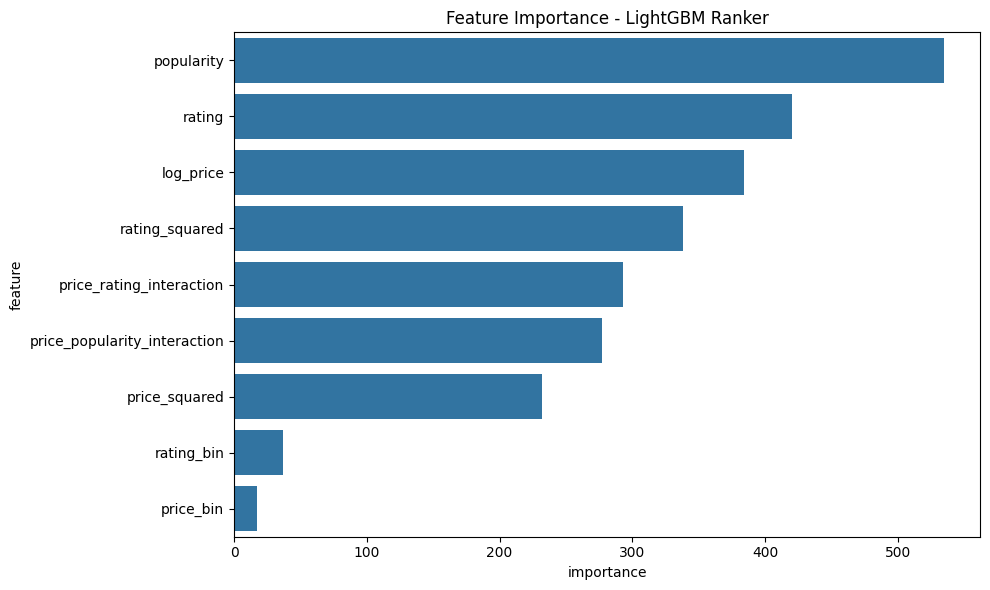

Важность признаков:
                        feature  importance
1                    popularity         535
0                        rating         420
2                     log_price         384
4                rating_squared         338
5      price_rating_interaction         293
6  price_popularity_interaction         277
3                 price_squared         232
8                    rating_bin          37
7                     price_bin          17

=== Анализ топ-3 признаков ===
popularity: корреляция с релевантностью = 0.243
rating: корреляция с релевантностью = 0.736
log_price: корреляция с релевантностью = -0.247


In [17]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': lgbm_ranker.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - LightGBM Ranker')
plt.tight_layout()
plt.show()

print("Важность признаков:")
print(feature_importance)

# Детальный анализ топ-3 признаков
print("\n=== Анализ топ-3 признаков ===")
top_features = feature_importance.head(3)['feature'].values

for feature in top_features:
    correlation = np.corrcoef(test_df[feature], test_df['relevance'])[0, 1]
    print(f"{feature}: корреляция с релевантностью = {correlation:.3f}")

In [18]:
# Проверка работы модели на конкретных примерах
def test_specific_cases(test_df, n_cases=2):
    """Тестирование на конкретных случаях"""

    for query_id in test_df['query_id'].unique()[:n_cases]:
        query_data = test_df[test_df['query_id'] == query_id].sort_values('predicted_score', ascending=False)

        print(f"\n{'='*50}")
        print(f"Запрос {query_id} (документов: {len(query_data)})")
        print(f"{'='*50}")

        print("Ранжирование по модели:")
        print("Позиция | Релевантность | Предсказание | Лог_цена | Рейтинг | Популярность")
        print("-" * 70)

        for i, (idx, row) in enumerate(query_data.head().iterrows(), 1):
            print(f"{i:7} | {row['relevance']:11} | {row['predicted_score']:11.3f} | {row['log_price']:8.2f} | {row['rating']:7.2f} | {row['popularity']:10.2f}")

test_specific_cases(test_df)


Запрос 10 (документов: 13)
Ранжирование по модели:
Позиция | Релевантность | Предсказание | Лог_цена | Рейтинг | Популярность
----------------------------------------------------------------------
      1 |         2.0 |       7.491 |    -0.71 |    1.02 |       0.50
      2 |         2.0 |       6.171 |     0.38 |    1.14 |      -0.99
      3 |         2.0 |       5.603 |     0.71 |    0.48 |       1.29
      4 |         2.0 |       4.138 |    -1.43 |   -0.72 |       1.27
      5 |         2.0 |       4.006 |     0.77 |    0.35 |       0.90

Запрос 23 (документов: 4)
Ранжирование по модели:
Позиция | Релевантность | Предсказание | Лог_цена | Рейтинг | Популярность
----------------------------------------------------------------------
      1 |         2.0 |       6.937 |     0.36 |    1.21 |       0.57
      2 |         2.0 |       5.409 |     0.98 |    1.68 |       0.10
      3 |         2.0 |       4.553 |     1.08 |    1.42 |       1.69
      4 |         1.0 |      -5.829 |     0.8

#zz